# Finding Repeat Customers

After using Spark SQL to answer business questions about their data, Distributed Discounts is convinced in the power of big data and Spark. They have been collecting more data and hope that this data can be used to predict whether a first-time customer will be a repeat buyer. They figure that if they can predict this, then they can appropriately advertise to those customers. Our job is to build this machine learning model and use it to predict which customers will be repeat buyers!

### Plan of Action

1. Read the Data Dictionary to understand the format of the new data files.
2. Create a SparkSession and import the data to Python as Spark DataFrames, making sure to consider the schema of our DataFrames. Join the data into new tables as necessary.
3. Clean and preprocess the labeled data for use in a machine learning model. Create a preprocessing pipeline to handle non-numeric features. During this step, consider whether there are any features we don't want to use and justify our decision.
4. Split the labeled data into training and test sets. Train and evaluate a logistic regression model using these datasets.
5. Use our model to predict whether or not customers in the unlabeled dataset will be repeat customers.
6. Create a PowerPoint presentation for the Distributed Discounts team describing the work that we did, the decisions that we had to make along the way, and the outcome of the project.

### Data Dictionary

- `capstone_customers.csv`: A dataset containing historical data about Distributed Discounts' customers. It contains fields for `customer_id`, `customer_invoices`, and whether or not the customer was a `repeat_customer`.
- `capstone_invoices.csv`: A dataset containing historical data about orders made from Distributed Discounts. Each row contains information about the order, including a `customer_id` field which can be joined with the customers data.
- `capstone_recent_customers.csv`: A dataset containing information about recent customers. This contains similar information as the `capstone_customers` dataset, but it is missing the `repeat_customer` field because these are brand new customers. The goal is to use your machine learning model to predict whether these customers will be repeat customers.
- `capstone_recent_invoices.csv`: A dataset containing information about orders made by recent customers. This dataset is very similar to `capstone_invoices.csv`, but it contains data that can be joined to the recent customers data.

### Create a SparkSession and Import Your Data

In [ ]:
import os
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.mllib.stat import Statistics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoderEstimator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression

%env JAVA_HOME = /usr/lib/jvm/java-8-openjdk-amd64



env: JAVA_HOME=/usr/lib/jvm/java-8-openjdk-amd64


## goal is to predict whether the customers in capstone_recent_customers will be repeat customers with ur ML model

In [ ]:
spark = SparkSession.builder \
      .master("local[1]") \
      .appName("Preparing Data with PySpark") \
      .config("spark.driver.memory", "5g") \
      .config("spark.executor.memory", "5g") \
      .getOrCreate()

sc = spark.sparkContext

In [ ]:
#Read in data
customers_data = spark.read.option("header", "true").csv("capstone_customers.csv")
invoices_data = spark.read.option("header", "true").csv("capstone_invoices.csv")
recent_customers_data = spark.read.option("header", "true").csv("capstone_recent_customers.csv")
recent_invoices_data = spark.read.option("header", "true").csv("capstone_recent_invoices.csv")

In [ ]:
#Inspect each CSV
customers_data.limit(5).toPandas()

,customer_id,customer_type,repeat_customer
0,81769,non-member,0
1,59586,member,0
2,27974,non-member,0
3,71976,non-member,0
4,52509,non-member,0


In [ ]:
invoices_data.limit(5).toPandas()

,invoice_id,product_id,customer_id,days_until_shipped,product_line,total
0,817-69-8206-B,H013,81769,7,Home,92.66
1,595-86-2894-C,E305,59586,8,Electronics,429.9
2,279-74-2924-B,B002,27974,7,Health,269.25
3,719-76-3868-C,H246,71976,6,Home,148.14
4,525-09-8450-B,E302,52509,4,Electronics,172.8


In [ ]:
recent_customers_data.limit(5).toPandas()

,customer_id,customer_type
0,80270,member
1,87546,non-member
2,29121,non-member
3,50002,member
4,32678,non-member


In [ ]:
recent_invoices_data.limit(5).toPandas()

,invoice_id,product_id,customer_id,days_until_shipped,product_line,total
0,802-70-5316-A,B004,80270,7,Health,499.66
1,875-46-5808-B,E303,87546,6,Electronics,304.4
2,291-21-5991-B,H014,29121,9,Home,368.13
3,500-02-2261-C,B006,50002,8,Health,724.0
4,326-78-5178-C,T202,32678,5,Travel,476.84


### Clean Our Data and Inspect Numeric Features

In [ ]:
#Counting rows of each dataset
print(f"customers_data: {customers_data.count()}")
print(f"invoices_data: {invoices_data.count()}")
print(f"recent_customers_data: {recent_customers_data.count()}")
print(f"recent_invoices_data: {recent_invoices_data.count()}")

customers_data: 652
invoices_data: 652
recent_customers_data: 19
recent_invoices_data: 19


In [ ]:
#Drop nulls/checking to make sure not too much data is lost- in that case we would fill them with Str "n/a"
customers_data_dropNa = customers_data.dropna()
print(f"customers_data_dropNa: {customers_data_dropNa.count()}")
invoices_data_dropNa = invoices_data.dropna()
print(f"invoices_data_dropNa: {invoices_data_dropNa.count()}")
recent_customers_data_dropNa = recent_customers_data.dropna()
print(f"recent_customers_data_dropNa: {recent_customers_data_dropNa.count()}")
recent_invoices_dropNa = recent_invoices_data.dropna()
print(f"recent_invoices_dropNa: {recent_invoices_dropNa.count()}")

customers_data_dropNa: 651
invoices_data_dropNa: 651
recent_customers_data_dropNa: 19
recent_invoices_dropNa: 19


In [ ]:
#Inspecting Schemas of each CSV
customers_data_dropNa.printSchema()
invoices_data_dropNa.printSchema()
recent_customers_data_dropNa.printSchema()
recent_invoices_dropNa.printSchema()

root
 |-- customer_id: string (nullable = true)
 |-- customer_type: string (nullable = true)
 |-- repeat_customer: string (nullable = true)

root
 |-- invoice_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- days_until_shipped: string (nullable = true)
 |-- product_line: string (nullable = true)
 |-- total: string (nullable = true)

root
 |-- customer_id: string (nullable = true)
 |-- customer_type: string (nullable = true)

root
 |-- invoice_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- days_until_shipped: string (nullable = true)
 |-- product_line: string (nullable = true)
 |-- total: string (nullable = true)



In [ ]:
customers_data.select('repeat_customer').distinct().show()

+---------------+
|repeat_customer|
+---------------+
|              0|
|              1|
+---------------+



In [ ]:
#Updating Schema of customers_csv col Customer ID and repeat_customer to IntegerType
schema_customers = StructType([
    StructField("customer_id", IntegerType(), True),
    StructField("customer_type", StringType(), True),
    StructField("repeat_customer", IntegerType(), True)
])

In [ ]:
#Reading in Customer csv again with our updated schema AND dropping nulls
customers_data = spark.read.schema(schema_customers).option("header", "true").option("mode", "DROPMALFORMED").csv("capstone_customers.csv").dropna()

In [ ]:
#Inspect and print new schema
customers_data.printSchema()

root
 |-- customer_id: integer (nullable = true)
 |-- customer_type: string (nullable = true)
 |-- repeat_customer: integer (nullable = true)



In [ ]:
#Updating Invoices csv schema col customer_id and days_until_shipped to integer
schema_invoices = StructType([
    StructField("invoice_id", StringType(), True),
    StructField("product_id", StringType(), True),
    StructField("customer_id", IntegerType(), True),
    StructField("days_until_shipped", IntegerType(), True),
    StructField("product_line", StringType(), True),
    StructField("total", StringType(), True)
])

In [ ]:
#import invoices data csv with new schema and drop nulls
invoices_data = spark.read.schema(schema_invoices).option("header", "true").option("mode", "DROPMALFORMED").csv("capstone_invoices.csv").dropna()

In [ ]:
#Inspect invoices schema
invoices_data.printSchema()

root
 |-- invoice_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- days_until_shipped: integer (nullable = true)
 |-- product_line: string (nullable = true)
 |-- total: string (nullable = true)



In [ ]:
invoices_data.limit(5).toPandas()

,invoice_id,product_id,customer_id,days_until_shipped,product_line,total
0,817-69-8206-B,H013,81769,7,Home,92.66
1,595-86-2894-C,E305,59586,8,Electronics,429.9
2,279-74-2924-B,B002,27974,7,Health,269.25
3,719-76-3868-C,H246,71976,6,Home,148.14
4,525-09-8450-B,E302,52509,4,Electronics,172.8


In [ ]:
#Updating Schema of recent_customers csv col Customer ID to IntegerType
schema_recent_customers = StructType([
    StructField("customer_id", IntegerType(), True),
    StructField("customer_type", StringType(), True)
])

In [ ]:
#Reading in Customer csv again with our updated schema AND dropping nulls
recent_customers_data = spark.read.schema(schema_recent_customers).option("header", "true").option("mode", "DROPMALFORMED").csv("capstone_recent_customers.csv").dropna()

In [ ]:
#Check schema
recent_customers_data.printSchema()

root
 |-- customer_id: integer (nullable = true)
 |-- customer_type: string (nullable = true)



In [ ]:
recent_customers_data.limit(5).toPandas()

,customer_id,customer_type
0,80270,member
1,87546,non-member
2,29121,non-member
3,50002,member
4,32678,non-member


In [ ]:
#Updating recent_invoices csv schema col customer_id and days_until_shipped to integer
schema_recent_invoices = StructType([
    StructField("invoice_id", StringType(), True),
    StructField("product_id", StringType(), True),
    StructField("customer_id", IntegerType(), True),
    StructField("days_until_shipped", IntegerType(), True),
    StructField("product_line", StringType(), True),
    StructField("total", StringType(), True)
])

In [ ]:
#import invoices data csv with new schema and drop nulls
recent_invoices_data = spark.read.schema(schema_recent_invoices).option("header", "true").option("mode", "DROPMALFORMED").csv("capstone_recent_invoices.csv").dropna()

In [ ]:
#Check schema
recent_invoices_data.printSchema()

root
 |-- invoice_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- days_until_shipped: integer (nullable = true)
 |-- product_line: string (nullable = true)
 |-- total: string (nullable = true)



In [ ]:
recent_invoices_data.limit(5).toPandas()

,invoice_id,product_id,customer_id,days_until_shipped,product_line,total
0,802-70-5316-A,B004,80270,7,Health,499.66
1,875-46-5808-B,E303,87546,6,Electronics,304.4
2,291-21-5991-B,H014,29121,9,Home,368.13
3,500-02-2261-C,B006,50002,8,Health,724.0
4,326-78-5178-C,T202,32678,5,Travel,476.84


In [ ]:
#create a view from our dataframe that will act as a table that we can query for CUSTOMERS
customers_data.createOrReplaceTempView("customers")


In [ ]:
result_customers = spark.sql(
    "select \
        customer_id, \
        customer_type, \
        repeat_customer \
    from customers")

result_customers.show(25, truncate=False)

+-----------+-------------+---------------+
|customer_id|customer_type|repeat_customer|
+-----------+-------------+---------------+
|81769      |non-member   |0              |
|59586      |member       |0              |
|27974      |non-member   |0              |
|71976      |non-member   |0              |
|52509      |non-member   |0              |
|64911      |member       |0              |
|47724      |member       |0              |
|18609      |non-member   |0              |
|73070      |non-member   |0              |
|77906      |non-member   |0              |
|72186      |non-member   |0              |
|78184      |non-member   |0              |
|58511      |member       |1              |
|14841      |non-member   |1              |
|38627      |non-member   |0              |
|73050      |member       |0              |
|31113      |member       |0              |
|31522      |member       |0              |
|77668      |non-member   |0              |
|22896      |non-member   |0    

In [ ]:
#create a view from our dataframe that will act as a table that we can query for invoice
invoices_data.createOrReplaceTempView("invoices")

In [ ]:
result_invoices = spark.sql(
    "select \
        invoice_id, \
        product_id, \
        customer_id, \
        days_until_shipped, \
        product_line,  \
        total \
    from invoices")

result_invoices.show(25, truncate=False)


+-------------+----------+-----------+------------------+--------------+------+
|invoice_id   |product_id|customer_id|days_until_shipped|product_line  |total |
+-------------+----------+-----------+------------------+--------------+------+
|817-69-8206-B|H013      |81769      |7                 |Home          |92.66 |
|595-86-2894-C|E305      |59586      |8                 |Electronics   |429.9 |
|279-74-2924-B|B002      |27974      |7                 |Health        |269.25|
|719-76-3868-C|H246      |71976      |6                 |Home          |148.14|
|525-09-8450-B|E302      |52509      |4                 |Electronics   |172.8 |
|649-11-3678-C|T260      |64911      |6                 |Travel        |251.34|
|477-24-6490-B|H245      |47724      |7                 |Home          |265.6 |
|186-09-3669-C|A056      |18609      |5                 |Fashion       |62.12 |
|730-70-9830-C|A056      |73070      |6                 |Fashion       |124.24|
|779-06-0012-C|F401      |77906      |3 

In [ ]:
#Joining customer_data with invoice_data
combined_table = customers_data \
            .join(invoices_data, customers_data.customer_id==invoices_data.customer_id, 'inner')  \
            .select(customers_data.customer_id, "customer_type","repeat_customer","invoice_id", "product_id", "days_until_shipped", "product_line", "total")

In [ ]:
combined_table.show()

+-----------+-------------+---------------+-------------+----------+------------------+--------------+------+
|customer_id|customer_type|repeat_customer|   invoice_id|product_id|days_until_shipped|  product_line| total|
+-----------+-------------+---------------+-------------+----------+------------------+--------------+------+
|      81769|   non-member|              0|817-69-8206-B|      H013|                 7|          Home| 92.66|
|      59586|       member|              0|595-86-2894-C|      E305|                 8|   Electronics| 429.9|
|      27974|   non-member|              0|279-74-2924-B|      B002|                 7|        Health|269.25|
|      71976|   non-member|              0|719-76-3868-C|      H246|                 6|          Home|148.14|
|      52509|   non-member|              0|525-09-8450-B|      E302|                 4|   Electronics| 172.8|
|      64911|       member|              0|649-11-3678-C|      T260|                 6|        Travel|251.34|
|      477

In [ ]:
#convert total to int
combined_table = combined_table.withColumn("total", round(col("total")).cast("int"))
print((combined_table).count())

651


In [ ]:
#Checking for any recurring customers
from pyspark.sql import functions as F

duplicates_df = combined_table.groupBy("customer_id").agg(F.count("*").alias("count"))

duplicates = duplicates_df.filter(duplicates_df["count"] > 1)

duplicates.show()

+-----------+-----+
|customer_id|count|
+-----------+-----+
+-----------+-----+



In [ ]:
#Check schema
combined_table.printSchema()

root
 |-- customer_id: integer (nullable = true)
 |-- customer_type: string (nullable = true)
 |-- repeat_customer: integer (nullable = true)
 |-- invoice_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- days_until_shipped: integer (nullable = true)
 |-- product_line: string (nullable = true)
 |-- total: integer (nullable = true)



In [ ]:
combined_table.limit(5).toPandas()

,customer_id,customer_type,repeat_customer,invoice_id,product_id,days_until_shipped,product_line,total
0,81769,non-member,0,817-69-8206-B,H013,7,Home,93
1,59586,member,0,595-86-2894-C,E305,8,Electronics,430
2,27974,non-member,0,279-74-2924-B,B002,7,Health,269
3,71976,non-member,0,719-76-3868-C,H246,6,Home,148
4,52509,non-member,0,525-09-8450-B,E302,4,Electronics,173


In [ ]:
#create a view from our dataframe that will act as a table that we can query for RECENT CUSTOMERS
recent_customers_data.createOrReplaceTempView("recent_customers")


In [ ]:
result_recent_customers = spark.sql(
    "select \
        customer_id, \
        customer_type \
    from recent_customers")

result_recent_customers.show(25, truncate=False)

+-----------+-------------+
|customer_id|customer_type|
+-----------+-------------+
|80270      |member       |
|87546      |non-member   |
|29121      |non-member   |
|50002      |member       |
|32678      |non-member   |
|12747      |non-member   |
|24172      |member       |
|58902      |non-member   |
|31423      |member       |
|73061      |member       |
|78596      |member       |
|23403      |member       |
|45712      |non-member   |
|57567      |non-member   |
|65098      |non-member   |
|55686      |member       |
|39969      |member       |
|39031      |non-member   |
|46801      |non-member   |
+-----------+-------------+



In [ ]:
#create a view from our dataframe that will act as a table that we can query for RECENT invoice
recent_invoices_data.createOrReplaceTempView("recent_invoices")

In [ ]:
result_recent_invoices = spark.sql(
    "select \
        invoice_id, \
        product_id, \
        customer_id, \
        days_until_shipped, \
        product_line,  \
        total \
    from recent_invoices")

result_recent_invoices.show(25, truncate=False)


+-------------+----------+-----------+------------------+--------------+------+
|invoice_id   |product_id|customer_id|days_until_shipped|product_line  |total |
+-------------+----------+-----------+------------------+--------------+------+
|802-70-5316-A|B004      |80270      |7                 |Health        |499.66|
|875-46-5808-B|E303      |87546      |6                 |Electronics   |304.4 |
|291-21-5991-B|H014      |29121      |9                 |Home          |368.13|
|500-02-2261-C|B006      |50002      |8                 |Health        |724.0 |
|326-78-5178-C|T202      |32678      |5                 |Travel        |476.84|
|127-47-6963-A|E034      |12747      |8                 |Electronics   |328.65|
|241-72-9525-B|E305      |24172      |7                 |Electronics   |515.88|
|589-02-8023-A|H017      |58902      |8                 |Home          |867.2 |
|314-23-4520-C|B004      |31423      |4                 |Health        |142.76|
|730-61-8757-B|F406      |73061      |6 

In [ ]:
#Joining recent_customers_data with recent_invoices_data
recent_combined_table = recent_customers_data \
            .join(recent_invoices_data, recent_customers_data.customer_id==recent_invoices_data.customer_id, 'inner')  \
            .select(recent_customers_data.customer_id, "customer_type","invoice_id", "product_id", "days_until_shipped", "product_line", "total")

In [ ]:
recent_combined_table.show()

+-----------+-------------+-------------+----------+------------------+--------------+------+
|customer_id|customer_type|   invoice_id|product_id|days_until_shipped|  product_line| total|
+-----------+-------------+-------------+----------+------------------+--------------+------+
|      80270|       member|802-70-5316-A|      B004|                 7|        Health|499.66|
|      87546|   non-member|875-46-5808-B|      E303|                 6|   Electronics| 304.4|
|      29121|   non-member|291-21-5991-B|      H014|                 9|          Home|368.13|
|      50002|       member|500-02-2261-C|      B006|                 8|        Health| 724.0|
|      32678|   non-member|326-78-5178-C|      T202|                 5|        Travel|476.84|
|      12747|   non-member|127-47-6963-A|      E034|                 8|   Electronics|328.65|
|      24172|       member|241-72-9525-B|      E305|                 7|   Electronics|515.88|
|      58902|   non-member|589-02-8023-A|      H017|        

In [ ]:
#convert total to int
recent_combined_table = recent_combined_table.withColumn("total", round(col("total")).cast("int"))

In [ ]:
recent_combined_table.printSchema()

root
 |-- customer_id: integer (nullable = true)
 |-- customer_type: string (nullable = true)
 |-- invoice_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- days_until_shipped: integer (nullable = true)
 |-- product_line: string (nullable = true)
 |-- total: integer (nullable = true)



### Create a Preprocessing Pipeline to Handle Non-Numeric Features

## INDEXER

In [ ]:

indexer = StringIndexer(inputCol='customer_type', outputCol='customer_type_index')
combined_table_indexed = indexer.fit(combined_table).transform(combined_table)


combined_table_indexed.select('customer_type', 'customer_type_index').show()

+-------------+-------------------+
|customer_type|customer_type_index|
+-------------+-------------------+
|   non-member|                1.0|
|       member|                0.0|
|   non-member|                1.0|
|   non-member|                1.0|
|   non-member|                1.0|
|       member|                0.0|
|       member|                0.0|
|   non-member|                1.0|
|   non-member|                1.0|
|   non-member|                1.0|
|   non-member|                1.0|
|   non-member|                1.0|
|       member|                0.0|
|   non-member|                1.0|
|   non-member|                1.0|
|       member|                0.0|
|       member|                0.0|
|       member|                0.0|
|   non-member|                1.0|
|   non-member|                1.0|
+-------------+-------------------+
only showing top 20 rows



In [ ]:
#We retrieve our numeric columns
numeric_features = [t[0] for t in combined_table_indexed.dtypes if t[1] != 'string']
print(numeric_features)

['customer_id', 'repeat_customer', 'days_until_shipped', 'total', 'customer_type_index']


In [ ]:
#We get our dataframe of numeric data using the select() function
numeric_features_df = combined_table_indexed.select(numeric_features)
numeric_features_df.limit(5).toPandas()

,customer_id,repeat_customer,days_until_shipped,total,customer_type_index
0,81769,0,7,93,1.0
1,59586,0,8,430,0.0
2,27974,0,7,269,1.0
3,71976,0,6,148,1.0
4,52509,0,4,173,1.0


In [ ]:
#We drop our target variable and customer_id
numeric_features_df = numeric_features_df.drop("customer_id", "repeat_customer")
numeric_features_df.limit(5).toPandas()

,days_until_shipped,total,customer_type_index
0,7,93,1.0
1,8,430,0.0
2,7,269,1.0
3,6,148,1.0
4,4,173,1.0


In [ ]:
#We ge the RDD from our dataframe object and use the map() function to only retrieve the row data
features_rdd = numeric_features_df.rdd.map(lambda row: row[0:])
features_rdd.toDF().limit(5).toPandas()

,_1,_2,_3
0,7,93,1.0
1,8,430,0.0
2,7,269,1.0
3,6,148,1.0
4,4,173,1.0


In [ ]:
#We create our correlation matrix and convert it to a dataframe
corr_mat = Statistics.corr(features_rdd, method ='pearson')
corr_matrix_df = pd.DataFrame(corr_mat)

In [ ]:
#We set numeric_features AGAIN after dropping target variable and customer_id
numeric_features = [t[0] for t in numeric_features_df.dtypes if t[1] != 'string']
print(numeric_features)

['days_until_shipped', 'total', 'customer_type_index']


<AxesSubplot:title={'center':'Feature Correlation Matrix'}>

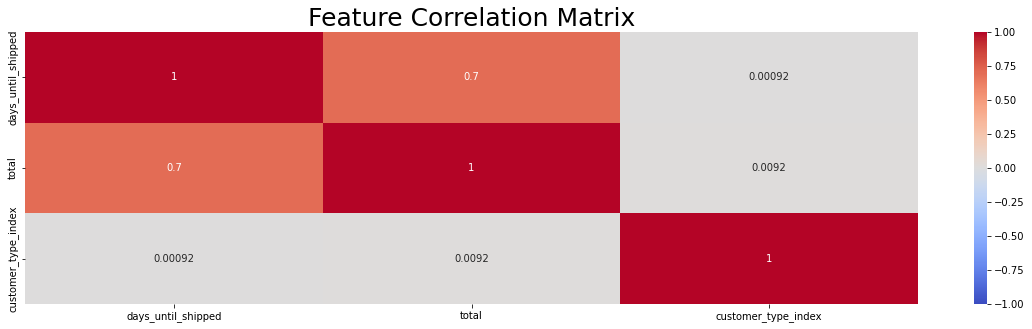

In [ ]:
plt.figure(figsize=(20,5))
plt.title("Feature Correlation Matrix", fontsize = 25)

sns.heatmap(corr_matrix_df, xticklabels=numeric_features, yticklabels=numeric_features, cmap="coolwarm", annot=True, vmin = -1, vmax = 1)

In [ ]:
#Now we include repeat_customer

#We retrieve our numeric columns
numeric_features = [t[0] for t in combined_table_indexed.dtypes if t[1] != 'string']
print(numeric_features)


['customer_id', 'repeat_customer', 'days_until_shipped', 'total', 'customer_type_index']


In [ ]:
#We get our dataframe of numeric data using the select() function
numeric_features_df = combined_table_indexed.select(numeric_features)
numeric_features_df.limit(5).toPandas()

,customer_id,repeat_customer,days_until_shipped,total,customer_type_index
0,81769,0,7,93,1.0
1,59586,0,8,430,0.0
2,27974,0,7,269,1.0
3,71976,0,6,148,1.0
4,52509,0,4,173,1.0


In [ ]:
#We drop only customer_id
numeric_features_df = numeric_features_df.drop("customer_id")
numeric_features_df.limit(5).toPandas()

,repeat_customer,days_until_shipped,total,customer_type_index
0,0,7,93,1.0
1,0,8,430,0.0
2,0,7,269,1.0
3,0,6,148,1.0
4,0,4,173,1.0


In [ ]:
#We ge the RDD from our dataframe object and use the map() function to only retrieve the row data
features_rdd = numeric_features_df.rdd.map(lambda row: row[0:])
features_rdd.toDF().limit(5).toPandas()

,_1,_2,_3,_4
0,0,7,93,1.0
1,0,8,430,0.0
2,0,7,269,1.0
3,0,6,148,1.0
4,0,4,173,1.0


In [ ]:
#We createour correlation matrix and convert it to a dataframe
corr_mat = Statistics.corr(features_rdd, method ='pearson')
corr_matrix_df = pd.DataFrame(corr_mat)

In [ ]:
#We set numeric_features AGAIN after dropping customer_id
numeric_features = [t[0] for t in numeric_features_df.dtypes if t[1] != 'string']
print(numeric_features)

['repeat_customer', 'days_until_shipped', 'total', 'customer_type_index']


<AxesSubplot:title={'center':'Feature Correlation Matrix'}>

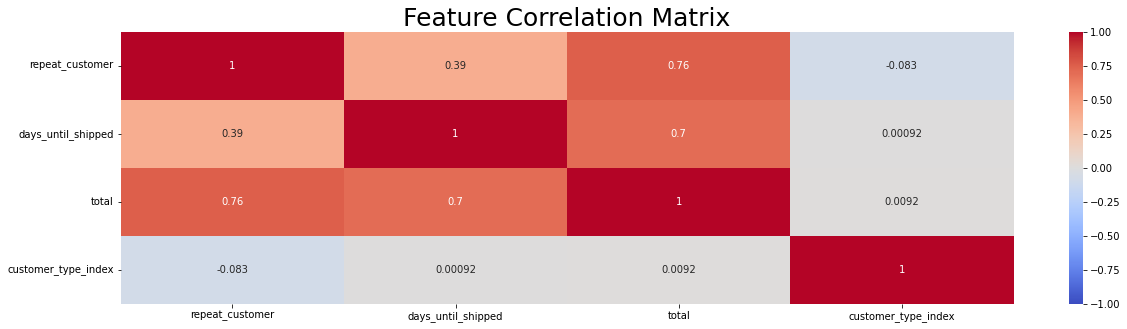

In [ ]:
plt.figure(figsize=(20,5))
plt.title("Feature Correlation Matrix", fontsize = 25)

sns.heatmap(corr_matrix_df, xticklabels=numeric_features, yticklabels=numeric_features, cmap="coolwarm", annot=True, vmin = -1, vmax = 1)

## ENCODER

In [ ]:
encoder = OneHotEncoderEstimator().setInputCols(['customer_type_index']).setOutputCols(['customer_type_encoded'])
combined_table_encoded = encoder.fit(combined_table_indexed).transform(combined_table_indexed)

combined_table_encoded.limit(5).toPandas()

,customer_id,customer_type,repeat_customer,invoice_id,product_id,days_until_shipped,product_line,total,customer_type_index,customer_type_encoded
0,81769,non-member,0,817-69-8206-B,H013,7,Home,93,1.0,(0.0)
1,59586,member,0,595-86-2894-C,E305,8,Electronics,430,0.0,(1.0)
2,27974,non-member,0,279-74-2924-B,B002,7,Health,269,1.0,(0.0)
3,71976,non-member,0,719-76-3868-C,H246,6,Home,148,1.0,(0.0)
4,52509,non-member,0,525-09-8450-B,E302,4,Electronics,173,1.0,(0.0)


## NUMERICAL ASSEMBLER

In [ ]:
#We transform all of our numerical input features into a vector of features represented by the column numerical_vectorized_features

numerical_assembler = VectorAssembler().\
    setInputCols(['days_until_shipped', 'total']).\
    setOutputCol('features')

assembler_df = numerical_assembler.transform(combined_table_encoded)
assembler_df.limit(5).toPandas()

,customer_id,customer_type,repeat_customer,invoice_id,product_id,days_until_shipped,product_line,total,customer_type_index,customer_type_encoded,features
0,81769,non-member,0,817-69-8206-B,H013,7,Home,93,1.0,(0.0),"[7.0, 93.0]"
1,59586,member,0,595-86-2894-C,E305,8,Electronics,430,0.0,(1.0),"[8.0, 430.0]"
2,27974,non-member,0,279-74-2924-B,B002,7,Health,269,1.0,(0.0),"[7.0, 269.0]"
3,71976,non-member,0,719-76-3868-C,H246,6,Home,148,1.0,(0.0),"[6.0, 148.0]"
4,52509,non-member,0,525-09-8450-B,E302,4,Electronics,173,1.0,(0.0),"[4.0, 173.0]"


## SCALER

In [ ]:
#We use StandardScaler() to standardize our features by subtracting the mean and dividing by the standard deviation
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler().\
    setInputCol('features').\
    setOutputCol('numerical_features')

scaler_model = scaler.fit(assembler_df)
scaler_df = scaler_model.transform(assembler_df)
pd.set_option('display.max_colwidth', 100)
scaler_df.select('features', 'numerical_features').limit(5).toPandas()

,features,numerical_features
0,"[7.0, 93.0]","[4.226833645535901, 0.39013579829558204]"
1,"[8.0, 430.0]","[4.830667023469601, 1.803853691044089]"
2,"[7.0, 269.0]","[4.226833645535901, 1.1284573090485115]"
3,"[6.0, 148.0]","[3.623000267602201, 0.6208612704058725]"
4,"[4.0, 173.0]","[2.4153335117348007, 0.725736485001459]"


## ASSEMBLER

In [ ]:
#We Add One Hot Encoded Features to Scaled Numerical Features Vector
assembler = VectorAssembler().\
    setInputCols(['numerical_features', 'customer_type_encoded']).\
    setOutputCol('all_features')

input_df = assembler.transform(scaler_df)
input_df.limit(5).toPandas()

,customer_id,customer_type,repeat_customer,invoice_id,product_id,days_until_shipped,product_line,total,customer_type_index,customer_type_encoded,features,numerical_features,all_features
0,81769,non-member,0,817-69-8206-B,H013,7,Home,93,1.0,(0.0),"[7.0, 93.0]","[4.226833645535901, 0.39013579829558204]","[4.226833645535901, 0.39013579829558204, 0.0]"
1,59586,member,0,595-86-2894-C,E305,8,Electronics,430,0.0,(1.0),"[8.0, 430.0]","[4.830667023469601, 1.803853691044089]","[4.830667023469601, 1.803853691044089, 1.0]"
2,27974,non-member,0,279-74-2924-B,B002,7,Health,269,1.0,(0.0),"[7.0, 269.0]","[4.226833645535901, 1.1284573090485115]","[4.226833645535901, 1.1284573090485115, 0.0]"
3,71976,non-member,0,719-76-3868-C,H246,6,Home,148,1.0,(0.0),"[6.0, 148.0]","[3.623000267602201, 0.6208612704058725]","[3.623000267602201, 0.6208612704058725, 0.0]"
4,52509,non-member,0,525-09-8450-B,E302,4,Electronics,173,1.0,(0.0),"[4.0, 173.0]","[2.4153335117348007, 0.725736485001459]","[2.4153335117348007, 0.725736485001459, 0.0]"


In [ ]:
pipeline_stages = Pipeline().setStages([indexer,
                                        encoder,
                                        numerical_assembler,
                                        scaler,
                                        assembler])

In [ ]:
train, test = combined_table.randomSplit([0.8, 0.2], seed=2022)
print("Training Data Size: {}".format(str(train.count())))
print("Testing Data Size: {}".format(str(test.count())))

Training Data Size: 513
Testing Data Size: 138


In [ ]:

pipeline_model = pipeline_stages.fit(train)
train_transformed = pipeline_model.transform(train)
test_transformed = pipeline_model.transform(test)

In [ ]:

train_transformed.limit(5).toPandas()

,customer_id,customer_type,repeat_customer,invoice_id,product_id,days_until_shipped,product_line,total,customer_type_index,customer_type_encoded,features,numerical_features,all_features
0,10117,member,0,101-17-6199-A,H008,6,Home,223,1.0,(0.0),"[6.0, 223.0]","[3.5920134976948805, 0.9467614915699251]","[3.5920134976948805, 0.9467614915699251, 0.0]"
1,10277,non-member,0,102-77-2261-C,F402,4,Food and Drink,38,0.0,(1.0),"[4.0, 38.0]","[2.3946756651299204, 0.16133155461729665]","[2.3946756651299204, 0.16133155461729665, 1.0]"
2,10510,member,1,105-10-6182-A,A505,6,Fashion,235,1.0,(0.0),"[6.0, 235.0]","[3.5920134976948805, 0.9977082982911767]","[3.5920134976948805, 0.9977082982911767, 0.0]"
3,11005,member,0,110-05-6330-C,F444,5,Food and Drink,26,1.0,(0.0),"[5.0, 26.0]","[2.9933445814124005, 0.11038474789604508]","[2.9933445814124005, 0.11038474789604508, 0.0]"
4,11435,member,0,114-35-5271-B,H009,9,Home,481,1.0,(0.0),"[9.0, 481.0]","[5.388020246542321, 2.0421178360768337]","[5.388020246542321, 2.0421178360768337, 0.0]"


### Create, Train, and Evaluate a Logistic Regression Model. Inspect the Coefficients of the Model

In [ ]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'all_features', labelCol = 'repeat_customer', maxIter = 5)
lr_model = lr.fit(train_transformed)

In [ ]:

predictions = lr_model.transform(test_transformed)
predictions.select('repeat_customer','all_features','rawPrediction','prediction','probability').limit(5).toPandas()

,repeat_customer,all_features,rawPrediction,prediction,probability
0,1,"[5.388020246542321, 3.349752541922291, 0.0]","[-3.804103361292102, 3.804103361292102]",1.0,"[0.02179362090741505, 0.978206379092585]"
1,0,"[3.5920134976948805, 1.54114090331786, 1.0]","[0.9143988561930946, -0.9143988561930946]",0.0,"[0.7138994607352177, 0.2861005392647823]"
2,0,"[5.986689162824801, 2.373272079764969, 1.0]","[0.5543879134927647, -0.5543879134927647]",0.0,"[0.6351530200128316, 0.36484697998716836]"
3,1,"[2.9933445814124005, 1.923241953727247, 1.0]","[-0.8382137517641692, 0.8382137517641692]",1.0,"[0.3019111218362139, 0.6980888781637861]"
4,0,"[2.9933445814124005, 0.42455672267709643, 1.0]","[3.841233847532367, -3.841233847532367]",0.0,"[0.9789840535081223, 0.021015946491877532]"


In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol='repeat_customer', rawPredictionCol='rawPrediction')

print("Test Area under ROC: {}".format(evaluator.evaluate(predictions)))

Test Area under ROC: 0.9702149702149704


In [ ]:


accuracy = predictions.filter(predictions.repeat_customer == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

Accuracy :  0.9202898550724637


In [ ]:

weights = lr_model.coefficients
print("Model Weights:")
feature_names=['days_until_shipped', 'total', 'customer_type_index']
pd.DataFrame([float(w) for w in weights], columns=['Feature Weight'], index=feature_names)



Model Weights:


,Feature Weight
days_until_shipped,-0.934661
total,3.122369
customer_type_index,-0.750007


In [ ]:
count_df = predictions.groupBy("repeat_customer").count()
count_df.show()

+---------------+-----+
|repeat_customer|count|
+---------------+-----+
|              1|   39|
|              0|   99|
+---------------+-----+



### Clean and Preprocess the Recent Customer Data. Make Predictions About Which Recent Customers Will Be Repeat Customers

In [ ]:
recent_customers_transformed = pipeline_model.transform(recent_combined_table)

In [ ]:
#Make Predictions and view ALL repeat vs non-repeat customers
predictions_recent = lr_model.transform(recent_customers_transformed)
predictions.select('all_features','rawPrediction','prediction','probability').limit(20).toPandas()





,all_features,rawPrediction,prediction,probability
0,"[4.190682413977361, 2.122783613385482, 0.0]","[-1.0921588206341784, 1.0921588206341784]",1.0,"[0.2512119764128342, 0.7487880235871659]"
1,"[3.5920134976948805, 1.2906524369383732, 1.0]","[1.6965161603248102, -1.6965161603248102]",0.0,"[0.8450791774997624, 0.15492082250023764]"
2,"[5.388020246542321, 1.562368739451715, 1.0]","[2.5267746692814668, -2.5267746692814668]",0.0,"[0.9259976377949819, 0.07400236220501812]"
3,"[4.789351330259841, 3.073790672182178, 0.0]","[-3.5020010177168923, 3.5020010177168923]",1.0,"[0.02925534933947105, 0.9707446506605288]"
4,"[2.9933445814124005, 2.02513556716975, 1.0]","[-1.1563631636143588, 1.1563631636143588]",1.0,"[0.2393287452227739, 0.7606712547772262]"
5,"[4.789351330259841, 1.3967916176076474, 1.0]","[2.484215150018971, -2.484215150018971]",0.0,"[0.923027808134615, 0.07697219186538488]"
6,"[4.190682413977361, 2.1907126890138175, 0.0]","[-1.3042584285343044, 1.3042584285343044]",1.0,"[0.21344920278478194, 0.786550797215218]"
7,"[4.789351330259841, 3.6809067856104263, 1.0]","[-4.647634165622774, 4.647634165622774]",1.0,"[0.00949326406225118, 0.9905067359377487]"
8,"[2.3946756651299204, 0.6071161134282479, 0.0]","[1.9616567400802274, -1.9616567400802274]",0.0,"[0.8767121378900404, 0.12328786210995954]"
9,"[3.5920134976948805, 1.2566878991242054, 0.0]","[1.0525588665733778, -1.0525588665733778]",0.0,"[0.7412659689784399, 0.2587340310215601]"


In [ ]:
#Count number of predictions for repeat and non-repeat
customer_counts = predictions_recent.groupBy('prediction').count()

customer_counts.show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|   10|
|       1.0|    9|
+----------+-----+



In [ ]:
#We count how many repeat customers there are in historical dataset vs non-repeat
duplicate_counts = combined_table.groupBy("repeat_customer").count()

duplicates = duplicate_counts.filter(duplicate_counts["count"] > 1)

duplicates.show()

+---------------+-----+
|repeat_customer|count|
+---------------+-----+
|              1|  187|
|              0|  464|
+---------------+-----+



#  END OF NOTEBOOK

## Here I just did some feature engineering to address the class imbalance.
## I added product_line and extracted the store location code from the invoice_id as categorical columns and converted them to numerical indices
## This Section can be ignored

In [ ]:
#Extracting Last letter in Invoice_ID to create new column
combined_table_calc = combined_table.withColumn("store_location_code", expr("substring(invoice_id, length(invoice_id), 1)"))

In [ ]:
combined_table_calc.limit(5).toPandas()

,customer_id,customer_type,repeat_customer,invoice_id,product_id,days_until_shipped,product_line,total,store_location_code
0,81769,non-member,0,817-69-8206-B,H013,7,Home,93,B
1,59586,member,0,595-86-2894-C,E305,8,Electronics,430,C
2,27974,non-member,0,279-74-2924-B,B002,7,Health,269,B
3,71976,non-member,0,719-76-3868-C,H246,6,Home,148,C
4,52509,non-member,0,525-09-8450-B,E302,4,Electronics,173,B


In [ ]:
#Add store location code as categorical value
indexer1 = StringIndexer(inputCol='store_location_code', outputCol='store_location_index')
combined_table_indexed = indexer1.fit(combined_table_calc).transform(combined_table_calc)


combined_table_indexed.select('store_location_code', 'store_location_index').show()

+-------------------+--------------------+
|store_location_code|store_location_index|
+-------------------+--------------------+
|                  B|                 2.0|
|                  C|                 0.0|
|                  B|                 2.0|
|                  C|                 0.0|
|                  B|                 2.0|
|                  C|                 0.0|
|                  B|                 2.0|
|                  C|                 0.0|
|                  C|                 0.0|
|                  C|                 0.0|
|                  A|                 1.0|
|                  C|                 0.0|
|                  B|                 2.0|
|                  C|                 0.0|
|                  C|                 0.0|
|                  C|                 0.0|
|                  B|                 2.0|
|                  C|                 0.0|
|                  B|                 2.0|
|                  C|                 0.0|
+----------

In [ ]:
#Also adding customer type as categorical value
indexer2 = StringIndexer(inputCol='customer_type', outputCol='customer_type_index')
combined_table_indexed2 = indexer2.fit(combined_table_indexed).transform(combined_table_indexed)


combined_table_indexed2.select('customer_type', 'customer_type_index').show()

+-------------+-------------------+
|customer_type|customer_type_index|
+-------------+-------------------+
|   non-member|                1.0|
|       member|                0.0|
|   non-member|                1.0|
|   non-member|                1.0|
|   non-member|                1.0|
|       member|                0.0|
|       member|                0.0|
|   non-member|                1.0|
|   non-member|                1.0|
|   non-member|                1.0|
|   non-member|                1.0|
|   non-member|                1.0|
|       member|                0.0|
|   non-member|                1.0|
|   non-member|                1.0|
|       member|                0.0|
|       member|                0.0|
|       member|                0.0|
|   non-member|                1.0|
|   non-member|                1.0|
+-------------+-------------------+
only showing top 20 rows



In [ ]:
#Add product_line as categorical value
indexer3 = StringIndexer(inputCol='product_line', outputCol='product_line_index')
combined_table_indexed3 = indexer3.fit(combined_table_indexed2).transform(combined_table_indexed2)


combined_table_indexed3.select('product_line', 'product_line_index').show()

+--------------+------------------+
|  product_line|product_line_index|
+--------------+------------------+
|          Home|               2.0|
|   Electronics|               4.0|
|        Health|               5.0|
|          Home|               2.0|
|   Electronics|               4.0|
|        Travel|               3.0|
|          Home|               2.0|
|       Fashion|               1.0|
|       Fashion|               1.0|
|Food and Drink|               0.0|
|        Health|               5.0|
|       Fashion|               1.0|
|        Travel|               3.0|
|        Travel|               3.0|
|        Health|               5.0|
|Food and Drink|               0.0|
|        Travel|               3.0|
|        Travel|               3.0|
|   Electronics|               4.0|
|        Health|               5.0|
+--------------+------------------+
only showing top 20 rows



In [ ]:
#We retrieve our numeric columns
numeric_features = [t[0] for t in combined_table_indexed3.dtypes if t[1] != 'string']
print(numeric_features)

['customer_id', 'repeat_customer', 'days_until_shipped', 'total', 'store_location_index', 'customer_type_index', 'product_line_index']


In [ ]:
#We get our dataframe of numeric data using the select() function
numeric_features_df = combined_table_indexed3.select(numeric_features)
numeric_features_df.limit(5).toPandas()

,customer_id,repeat_customer,days_until_shipped,total,store_location_index,customer_type_index,product_line_index
0,81769,0,7,93,2.0,1.0,2.0
1,59586,0,8,430,0.0,0.0,4.0
2,27974,0,7,269,2.0,1.0,5.0
3,71976,0,6,148,0.0,1.0,2.0
4,52509,0,4,173,2.0,1.0,4.0


In [ ]:
#We drop customer_id
numeric_features_df = numeric_features_df.drop("customer_id")
numeric_features_df.limit(5).toPandas()

,repeat_customer,days_until_shipped,total,store_location_index,customer_type_index,product_line_index
0,0,7,93,2.0,1.0,2.0
1,0,8,430,0.0,0.0,4.0
2,0,7,269,2.0,1.0,5.0
3,0,6,148,0.0,1.0,2.0
4,0,4,173,2.0,1.0,4.0


In [ ]:
#We ge the RDD from our dataframe object and use the map() function to only retrieve the row data
features_rdd = numeric_features_df.rdd.map(lambda row: row[0:])
features_rdd.toDF().limit(5).toPandas()

,_1,_2,_3,_4,_5,_6
0,0,7,93,2.0,1.0,2.0
1,0,8,430,0.0,0.0,4.0
2,0,7,269,2.0,1.0,5.0
3,0,6,148,0.0,1.0,2.0
4,0,4,173,2.0,1.0,4.0


In [ ]:
#We create our correlation matrix and convert it to a dataframe
corr_mat = Statistics.corr(features_rdd, method ='pearson')
corr_matrix_df = pd.DataFrame(corr_mat)

In [ ]:
#We set numeric_features AGAIN after dropping customer_id
numeric_features = [t[0] for t in numeric_features_df.dtypes if t[1] != 'string']
print(numeric_features)

['repeat_customer', 'days_until_shipped', 'total', 'store_location_index', 'customer_type_index', 'product_line_index']


<AxesSubplot:title={'center':'Feature Correlation Matrix'}>

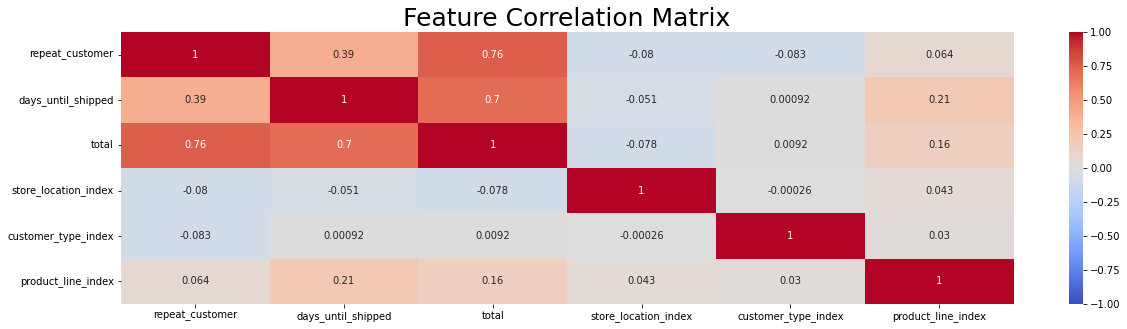

In [ ]:
plt.figure(figsize=(20,5))
plt.title("Feature Correlation Matrix", fontsize = 25)

sns.heatmap(corr_matrix_df, xticklabels=numeric_features, yticklabels=numeric_features, cmap="coolwarm", annot=True, vmin = -1, vmax = 1)

In [ ]:
#We encode the store_location into a numerical index
encoder1 = OneHotEncoderEstimator().setInputCols(['store_location_index']).setOutputCols(['store_location_encoded'])
combined_table_encoded = encoder1.fit(combined_table_indexed3).transform(combined_table_indexed3)

combined_table_encoded.limit(5).toPandas()

,customer_id,customer_type,repeat_customer,invoice_id,product_id,days_until_shipped,product_line,total,store_location_code,store_location_index,customer_type_index,product_line_index,store_location_encoded
0,81769,non-member,0,817-69-8206-B,H013,7,Home,93,B,2.0,1.0,2.0,"(0.0, 0.0)"
1,59586,member,0,595-86-2894-C,E305,8,Electronics,430,C,0.0,0.0,4.0,"(1.0, 0.0)"
2,27974,non-member,0,279-74-2924-B,B002,7,Health,269,B,2.0,1.0,5.0,"(0.0, 0.0)"
3,71976,non-member,0,719-76-3868-C,H246,6,Home,148,C,0.0,1.0,2.0,"(1.0, 0.0)"
4,52509,non-member,0,525-09-8450-B,E302,4,Electronics,173,B,2.0,1.0,4.0,"(0.0, 0.0)"


In [ ]:
#We encode the customer_type into a numerical index
encoder2 = OneHotEncoderEstimator().setInputCols(['customer_type_index']).setOutputCols(['customer_type_encoded'])
combined_table_encoded2 = encoder2.fit(combined_table_encoded).transform(combined_table_encoded)

combined_table_encoded2.limit(5).toPandas()

,customer_id,customer_type,repeat_customer,invoice_id,product_id,days_until_shipped,product_line,total,store_location_code,store_location_index,customer_type_index,product_line_index,store_location_encoded,customer_type_encoded
0,81769,non-member,0,817-69-8206-B,H013,7,Home,93,B,2.0,1.0,2.0,"(0.0, 0.0)",(0.0)
1,59586,member,0,595-86-2894-C,E305,8,Electronics,430,C,0.0,0.0,4.0,"(1.0, 0.0)",(1.0)
2,27974,non-member,0,279-74-2924-B,B002,7,Health,269,B,2.0,1.0,5.0,"(0.0, 0.0)",(0.0)
3,71976,non-member,0,719-76-3868-C,H246,6,Home,148,C,0.0,1.0,2.0,"(1.0, 0.0)",(0.0)
4,52509,non-member,0,525-09-8450-B,E302,4,Electronics,173,B,2.0,1.0,4.0,"(0.0, 0.0)",(0.0)


In [ ]:
#TESTING A COMBINED ENCODER
encoder4 = OneHotEncoderEstimator().setInputCols(['customer_type_index', 'product_line_index', 'store_location_index']).setOutputCols(['customer_type_encoded', 'product_line_encoded','store_location_encoded'])
encoder_model1 = encoder4.fit(combined_table_indexed3).transform(combined_table_indexed3)

encoder_model1.limit(5).toPandas()

,customer_id,customer_type,repeat_customer,invoice_id,product_id,days_until_shipped,product_line,total,store_location_code,store_location_index,customer_type_index,product_line_index,customer_type_encoded,product_line_encoded,store_location_encoded
0,81769,non-member,0,817-69-8206-B,H013,7,Home,93,B,2.0,1.0,2.0,(0.0),"(0.0, 0.0, 1.0, 0.0, 0.0)","(0.0, 0.0)"
1,59586,member,0,595-86-2894-C,E305,8,Electronics,430,C,0.0,0.0,4.0,(1.0),"(0.0, 0.0, 0.0, 0.0, 1.0)","(1.0, 0.0)"
2,27974,non-member,0,279-74-2924-B,B002,7,Health,269,B,2.0,1.0,5.0,(0.0),"(0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0)"
3,71976,non-member,0,719-76-3868-C,H246,6,Home,148,C,0.0,1.0,2.0,(0.0),"(0.0, 0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)"
4,52509,non-member,0,525-09-8450-B,E302,4,Electronics,173,B,2.0,1.0,4.0,(0.0),"(0.0, 0.0, 0.0, 0.0, 1.0)","(0.0, 0.0)"


In [ ]:
output_cols = encoder_model1.getOutputCols()
print("Output Cols: ", output_cols)

AttributeError: 'DataFrame' object has no attribute 'getOutputCols'

In [ ]:
#We encode the product_line into a numerical index
encoder3 = OneHotEncoderEstimator().setInputCols(['product_line_index']).setOutputCols(['product_line_encoded'])
combined_table_encoded3 = encoder3.fit(combined_table_encoded2).transform(combined_table_encoded2)

combined_table_encoded3.limit(5).toPandas()

,customer_id,customer_type,repeat_customer,invoice_id,product_id,days_until_shipped,product_line,total,store_location_code,store_location_index,customer_type_index,product_line_index,store_location_encoded,customer_type_encoded,product_line_encoded
0,81769,non-member,0,817-69-8206-B,H013,7,Home,93,B,2.0,1.0,2.0,"(0.0, 0.0)",(0.0),"(0.0, 0.0, 1.0, 0.0, 0.0)"
1,59586,member,0,595-86-2894-C,E305,8,Electronics,430,C,0.0,0.0,4.0,"(1.0, 0.0)",(1.0),"(0.0, 0.0, 0.0, 0.0, 1.0)"
2,27974,non-member,0,279-74-2924-B,B002,7,Health,269,B,2.0,1.0,5.0,"(0.0, 0.0)",(0.0),"(0.0, 0.0, 0.0, 0.0, 0.0)"
3,71976,non-member,0,719-76-3868-C,H246,6,Home,148,C,0.0,1.0,2.0,"(1.0, 0.0)",(0.0),"(0.0, 0.0, 1.0, 0.0, 0.0)"
4,52509,non-member,0,525-09-8450-B,E302,4,Electronics,173,B,2.0,1.0,4.0,"(0.0, 0.0)",(0.0),"(0.0, 0.0, 0.0, 0.0, 1.0)"


In [ ]:
#We transform all of our numerical input features into a vector of features represented by the column numerical_vectorized_features

numerical_assembler1 = VectorAssembler().\
    setInputCols(['days_until_shipped', 'total']).\
    setOutputCol('features')

assembler_df = numerical_assembler1.transform(combined_table_encoded3)
assembler_df.limit(5).toPandas()

,customer_id,customer_type,repeat_customer,invoice_id,product_id,days_until_shipped,product_line,total,store_location_code,store_location_index,customer_type_index,product_line_index,store_location_encoded,customer_type_encoded,product_line_encoded,features
0,81769,non-member,0,817-69-8206-B,H013,7,Home,93,B,2.0,1.0,2.0,"(0.0, 0.0)",(0.0),"(0.0, 0.0, 1.0, 0.0, 0.0)","[7.0, 93.0]"
1,59586,member,0,595-86-2894-C,E305,8,Electronics,430,C,0.0,0.0,4.0,"(1.0, 0.0)",(1.0),"(0.0, 0.0, 0.0, 0.0, 1.0)","[8.0, 430.0]"
2,27974,non-member,0,279-74-2924-B,B002,7,Health,269,B,2.0,1.0,5.0,"(0.0, 0.0)",(0.0),"(0.0, 0.0, 0.0, 0.0, 0.0)","[7.0, 269.0]"
3,71976,non-member,0,719-76-3868-C,H246,6,Home,148,C,0.0,1.0,2.0,"(1.0, 0.0)",(0.0),"(0.0, 0.0, 1.0, 0.0, 0.0)","[6.0, 148.0]"
4,52509,non-member,0,525-09-8450-B,E302,4,Electronics,173,B,2.0,1.0,4.0,"(0.0, 0.0)",(0.0),"(0.0, 0.0, 0.0, 0.0, 1.0)","[4.0, 173.0]"


In [ ]:
#We use StandardScaler() to standardize our features by subtracting the mean and dividing by the standard deviation
from pyspark.ml.feature import StandardScaler

scaler1 = StandardScaler().\
    setInputCol('features').\
    setOutputCol('numerical_features')

scaler_model = scaler1.fit(assembler_df)
scaler_df = scaler_model.transform(assembler_df)
pd.set_option('display.max_colwidth', 100)
scaler_df.select('features', 'numerical_features').limit(5).toPandas()

,features,numerical_features
0,"[7.0, 93.0]","[4.226833645535901, 0.39013579829558204]"
1,"[8.0, 430.0]","[4.830667023469601, 1.803853691044089]"
2,"[7.0, 269.0]","[4.226833645535901, 1.1284573090485115]"
3,"[6.0, 148.0]","[3.623000267602201, 0.6208612704058725]"
4,"[4.0, 173.0]","[2.4153335117348007, 0.725736485001459]"


In [ ]:
#We Add One Hot Encoded Features to Scaled Numerical Features Vector
assembler1 = VectorAssembler().\
    setInputCols(['numerical_features', 'customer_type_encoded', 'product_line_encoded', 'store_location_encoded']).\
    setOutputCol('all_features')

input_df = assembler1.transform(scaler_df)
input_df.limit(5).toPandas()

,customer_id,customer_type,repeat_customer,invoice_id,product_id,days_until_shipped,product_line,total,store_location_code,store_location_index,customer_type_index,product_line_index,store_location_encoded,customer_type_encoded,product_line_encoded,features,numerical_features,all_features
0,81769,non-member,0,817-69-8206-B,H013,7,Home,93,B,2.0,1.0,2.0,"(0.0, 0.0)",(0.0),"(0.0, 0.0, 1.0, 0.0, 0.0)","[7.0, 93.0]","[4.226833645535901, 0.39013579829558204]","(4.226833645535901, 0.39013579829558204, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0)"
1,59586,member,0,595-86-2894-C,E305,8,Electronics,430,C,0.0,0.0,4.0,"(1.0, 0.0)",(1.0),"(0.0, 0.0, 0.0, 0.0, 1.0)","[8.0, 430.0]","[4.830667023469601, 1.803853691044089]","(4.830667023469601, 1.803853691044089, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0)"
2,27974,non-member,0,279-74-2924-B,B002,7,Health,269,B,2.0,1.0,5.0,"(0.0, 0.0)",(0.0),"(0.0, 0.0, 0.0, 0.0, 0.0)","[7.0, 269.0]","[4.226833645535901, 1.1284573090485115]","(4.226833645535901, 1.1284573090485115, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
3,71976,non-member,0,719-76-3868-C,H246,6,Home,148,C,0.0,1.0,2.0,"(1.0, 0.0)",(0.0),"(0.0, 0.0, 1.0, 0.0, 0.0)","[6.0, 148.0]","[3.623000267602201, 0.6208612704058725]","(3.623000267602201, 0.6208612704058725, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0)"
4,52509,non-member,0,525-09-8450-B,E302,4,Electronics,173,B,2.0,1.0,4.0,"(0.0, 0.0)",(0.0),"(0.0, 0.0, 0.0, 0.0, 1.0)","[4.0, 173.0]","[2.4153335117348007, 0.725736485001459]","(2.4153335117348007, 0.725736485001459, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0)"


In [ ]:
pipeline_stages = Pipeline().setStages([indexer1,
                                        indexer2,
                                        indexer3,
                                        encoder1,
                                        encoder2,
                                        encoder3,
                                        numerical_assembler1,
                                        scaler1,
                                        assembler1])

In [ ]:
train, test = combined_table_calc.randomSplit([0.8, 0.2], seed=2022)
print("Training Data Size: {}".format(str(train.count())))
print("Testing Data Size: {}".format(str(test.count())))


Training Data Size: 513
Testing Data Size: 138


In [ ]:
pipeline_model = pipeline_stages.fit(train)
train_transformed = pipeline_model.transform(train)
test_transformed = pipeline_model.transform(test)

In [ ]:
train_transformed.limit(5).toPandas()

,customer_id,customer_type,repeat_customer,invoice_id,product_id,days_until_shipped,product_line,total,store_location_code,store_location_index,customer_type_index,product_line_index,store_location_encoded,customer_type_encoded,product_line_encoded,features,numerical_features,all_features
0,10117,member,0,101-17-6199-A,H008,6,Home,223,A,0.0,1.0,1.0,"(1.0, 0.0)",(0.0),"(0.0, 1.0, 0.0, 0.0, 0.0)","[6.0, 223.0]","[3.5920134976948805, 0.9467614915699251]","(3.5920134976948805, 0.9467614915699251, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0)"
1,10277,non-member,0,102-77-2261-C,F402,4,Food and Drink,38,C,1.0,0.0,0.0,"(0.0, 1.0)",(1.0),"(1.0, 0.0, 0.0, 0.0, 0.0)","[4.0, 38.0]","[2.3946756651299204, 0.16133155461729665]","(2.3946756651299204, 0.16133155461729665, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0)"
2,10510,member,1,105-10-6182-A,A505,6,Fashion,235,A,0.0,1.0,4.0,"(1.0, 0.0)",(0.0),"(0.0, 0.0, 0.0, 0.0, 1.0)","[6.0, 235.0]","[3.5920134976948805, 0.9977082982911767]","(3.5920134976948805, 0.9977082982911767, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0)"
3,11005,member,0,110-05-6330-C,F444,5,Food and Drink,26,C,1.0,1.0,0.0,"(0.0, 1.0)",(0.0),"(1.0, 0.0, 0.0, 0.0, 0.0)","[5.0, 26.0]","[2.9933445814124005, 0.11038474789604508]","(2.9933445814124005, 0.11038474789604508, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0)"
4,11435,member,0,114-35-5271-B,H009,9,Home,481,B,2.0,1.0,1.0,"(0.0, 0.0)",(0.0),"(0.0, 1.0, 0.0, 0.0, 0.0)","[9.0, 481.0]","[5.388020246542321, 2.0421178360768337]","(5.388020246542321, 2.0421178360768337, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)"


In [ ]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'all_features', labelCol = 'repeat_customer', maxIter = 5)
lr_model = lr.fit(train_transformed)

In [ ]:
predictions = lr_model.transform(test_transformed)
predictions.select('repeat_customer','all_features','rawPrediction','prediction','probability').limit(5).toPandas()

,repeat_customer,all_features,rawPrediction,prediction,probability
0,1,"(5.388020246542321, 3.349752541922291, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0)","[-3.676930509980834, 3.676930509980834]",1.0,"[0.02467619499620453, 0.9753238050037955]"
1,0,"(3.5920134976948805, 1.54114090331786, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0)","[0.7495174373004657, -0.7495174373004657]",0.0,"[0.6790735420886259, 0.3209264579113741]"
2,0,"(5.986689162824801, 2.373272079764969, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0)","[0.5555128924306376, -0.5555128924306376]",0.0,"[0.6354136758421335, 0.3645863241578665]"
3,1,"(2.9933445814124005, 1.923241953727247, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","[-0.9986044457387548, 0.9986044457387548]",1.0,"[0.2692158924512091, 0.7307841075487909]"
4,0,"(2.9933445814124005, 0.42455672267709643, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0)","[3.870104719095642, -3.870104719095642]",0.0,"[0.9795699085033419, 0.02043009149665806]"


In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol='repeat_customer', rawPredictionCol='rawPrediction')

print("Test Area under ROC: {}".format(evaluator.evaluate(predictions)))

Test Area under ROC: 0.9601139601139601


In [ ]:
accuracy = predictions.filter(predictions.repeat_customer == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

Accuracy :  0.9130434782608695


In [ ]:
weights = lr_model.coefficients
print("Model Weights:")
feature_names=['days_until_shipped', 'total', 'customer_type_index', 'product_line_index', 'store_location_index']
pd.DataFrame([float(w) for w in weights], columns=['Feature Weight'], index=feature_names)



Model Weights:


ValueError: Shape of passed values is (10, 1), indices imply (5, 1)

In [ ]:
product_line_categories = combined_table_calc.select("product_line").distinct().count()
store_location_categories = combined_table_calc.select("store_location_code").distinct().count()

In [ ]:
print(product_line_categories)

6


In [ ]:
print(store_location_categories)

3
